# <center> Итоговый проект. Бриф “Агентство недвижимости”


## <center> Часть 1. Обработка и подготовка данных

### 0. Импорт библиотек

In [1]:
# стандартные библиотеки
import pandas as pd
import numpy as np
import ast 
from datetime import datetime as dt
import scipy.stats as sps
import category_encoders as ce 


# для визуализации
import matplotlib.pyplot as plt         
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

RS = 42

### 1. Загрузка данных

In [2]:
realty_data = pd.read_csv('data/data.csv')

realty_data.head()

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
0,Active,NaN,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,NaN,NaN,611019,"$418,000"
1,for sale,NaN,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,NaN,NaN,201916904,"$310,000"
2,for sale,NaN,single-family home,2005 Westridge Rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,NaN,yes,FR19221027,"$2,895,000"
3,for sale,NaN,single-family home,4311 Livingston Ave,8 Baths,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",yes,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",75205,5 Beds,TX,3.0,NaN,NaN,14191809,"$2,395,000"
4,for sale,NaN,lot/land,1524 Kiscoe St,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,32908,NaN,FL,NaN,NaN,NaN,861745,"$5,000"


> Данные не обработаны, содержат пропуски и нуждаются в кодировке.

### 2. Подготовка данных: их исследование, анализ и обработка

In [3]:
# удалим полные дубликаты
realty_data.drop_duplicates(inplace=True)

In [4]:
# общая информация о данных
realty_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 377135 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337218 non-null  object
 1   private pool  4181 non-null    object
 2   propertyType  342402 non-null  object
 3   street        377133 non-null  object
 4   baths         270827 non-null  object
 5   homeFacts     377135 non-null  object
 6   fireplace     103111 non-null  object
 7   city          377101 non-null  object
 8   schools       377135 non-null  object
 9   sqft          336585 non-null  object
 10  zipcode       377135 non-null  object
 11  beds          285881 non-null  object
 12  state         377135 non-null  object
 13  stories       226461 non-null  object
 14  mls-id        24942 non-null   object
 15  PrivatePool   40310 non-null   object
 16  MlsId         310266 non-null  object
 17  target        374655 non-null  object
dtypes: object(18)
memory usage: 5

> Удалим строки, которые содержат пропуски в признаках `city` и `target`, их совсем немного, но они помешают при будущей обработке.

In [5]:
realty_data = realty_data[realty_data['city'].notna()]
realty_data = realty_data[realty_data['target'].notna()]
realty_data = realty_data[
    realty_data['target']
    .apply(lambda x: True if '/mo' not in x else False)
]

realty_data.reset_index(inplace=True)

* #### Признак `status`

In [6]:
realty_data['status'].value_counts(normalize=True, dropna=False).mul(100).round(0)

status
for sale                   42.0
Active                     28.0
For sale                   12.0
NaN                        10.0
foreclosure                 2.0
                           ... 
Coming soon: Oct 29.        0.0
Coming soon: Dec 15.        0.0
Pending W/Backup Wanted     0.0
Pending Backups Wanted      0.0
Coming soon: Dec 23.        0.0
Name: proportion, Length: 156, dtype: float64

> Предварительно можно сделать вывод, что из этого признака можно выделить как минимум один бинарный признак - `is_active` (в продаже ли имущество). Хотя мне сложно понять, как это может повлиять на итоговую цену.
>
> Перед кодировкой попробуем отсортировать значения по смысловым категориям.

In [7]:
categories = {'foreclosed': ['foreclosed', 'contingent   foreclosure', 'foreclosure'],                                                   # (1) лишён права выкупа.
              'pre_foreclosure': ['pre foreclosure', 'pre foreclosure auction', 'pre-foreclosure / auction','pre-foreclosure'],          # (2) до выкупа.
              'backup': ['under contract show', 'under contract showing', 'under contract show', 'contract',                             # (3) предложение о покупке уже сделано, но не принято продавцом окончательно, и
              'active under contract', 'under contract   showing', 'under contract - show', 'under contract backups',                    #     он открыт для резервных предложений.
              'active backup', 'under contract taking back up offers', 'under contract w/ bckp', 'conting accpt backups',                                  
              'backup', 'accepting backups', 'active with offer', 'backup contract', 'pending take backups',                
              'pending - backup offer requested', 'pending taking backups', 'pending - taking backups', 'pending bring backup',
              'pending w/backup wanted', 'pending backups wanted', 'pending   continue to show   financing',
              'pending, continue to show', 'pending   continue to show', 'pending continue to show', 'pending - continue to show', 
              'contract p', 'uc continue to show'],                      
              'contigent': ['ct insp - inspection contingency', 'contingent - sale of home', 'active contingent',                        # (4) дополнительные обстоятельства (критерии, которым должен соответствовать
              'contingent   release', 'active/contingent', 'contingency 48 hr (+/ )', 'contingent - financing',                          #     продавец/покупатель до завершения сделки).
              'contingent lien holder release', 'contingent take backup', 'contingent show', 'contingent   no show', 
              'contingent escape', 'contract contingent on buyer sale', 'c continue show', 'contingent', 'contingent   show',  
              'contingent finance and inspection', 'active - contingent', 'active with contingencies',
              'pending with contingencies', 'conditional contract', 'contingency contract'],
              'auction': ['active auction', 'auction active', 'auction - active', ' / auction', 'active - auction', 'auction'],          # (5) продажа недвижимости с помощью аукциона.
              'option contract': ['pending w/escape clause', 'active option contract', 'option contract',                                # (6) предложение о покупке уже сделано, но покупатели могут передумать.
              'pending offer approval', 'offer pending signature', 'pending sale', 'option pending', 'p pending sale', 'p', 
              'pending', 'pending w/insp finance', 'cooling-off period'],
              'closed': ['under contract - no show', 'pending (do not show)', 'under contract', 'closed', 'accepted offer',              # (7) предложение о покупке уже сделано, продавец закрыт для резервных предложений.
              'u under contract'],
              'new': ['new construction', 'new'],                                                                                        # (8) новая постройка.
              'is_active': ['active', 'a active','reactivated', 'back on market', 'for sale', 'active option', 're activated',           # (9) продается. 
              'for rent', 'condo for rent', 'temporary active', 'apartment for rent', 'active with contract'],
              'price_change': ['price change'],                                                                                          # (10) новая цена.                                                                        
              'inspection': ['insp inspection contingency', 'pending inspection', 'due diligence period']}                               # (11) возможна инспекция.


def status_category(status):                                                    # функция для группировки значений по категориям
    if status is not np.nan:
        # для удобства приведем значение к нижнему регистру
        status = status.lower()
        
        for key, value in categories.items():
            if status in value:
                return key
        if status.split()[:2]==['coming', 'soon:']:
            return 'backup' 
        elif 'sold' in status:
            return 'closed'
        else:
            return 'unknown'
    else:
        return 'unknown'

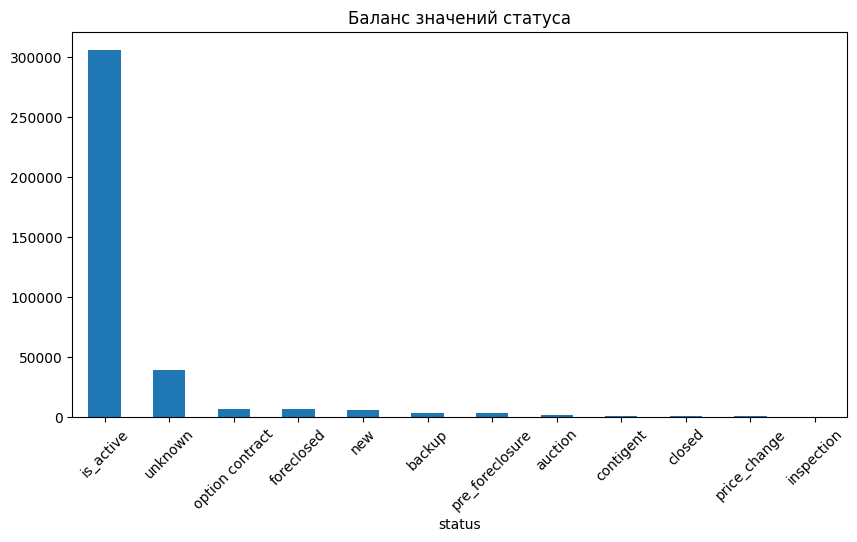

In [8]:
realty_data['status'] = realty_data['status'].apply(status_category)

plt.figure(figsize=(10, 5))
realty_data['status'].value_counts().plot(kind='bar')

plt.title('Баланс значений статуса')
plt.xticks(rotation=45)
plt.show()

> Абсолютное большинство значений говорит о том, продается ли дом, даже если не учитывать те категории, которые говорят о том же, но с нюансами. Значимую часть составляют неизвестные значения. Остальные - по ~2% и менее, поэтому по отдельности они скорее всего не будут информативными.

In [9]:
# кодируем признаки
statuses = pd.get_dummies(realty_data['status']).astype(int).drop('unknown', axis=1)

* #### Признаки `private pool` и `PrivatePool`

> Данные содержат два по сути идентичных столбца: `private pool` и `PrivatePool`, но один из них имеет значительно меньше пропусков. Стоит проверить, действительно ли он более информативен или же пропуски в нем закодированы иначе, а возможно столбцы дополняют друг друга.

In [10]:
mask1 = realty_data['private pool'].notna()
mask2 = realty_data['PrivatePool'].notna()
realty_data[['private pool', 'PrivatePool']][mask1&mask2]

,private pool,PrivatePool


In [11]:
print(realty_data['private pool'].unique(),
      realty_data['PrivatePool'].unique())

[nan 'Yes'] [nan 'yes' 'Yes']


> Столбцы не имеют пересечения, пропуски закодированы одинаково, а следовательно, эти столбцы дополняют друг друга. 
>
> Перейдем к кодировке. Так как в худшем случае бассейна нет, возвращаем нули вместо пропусков.

In [12]:
private_pool = pd.Series(realty_data['PrivatePool'].fillna(realty_data['private pool']).apply(lambda x: 0 if x is np.nan else 1))
private_pool.name = 'private_pool'

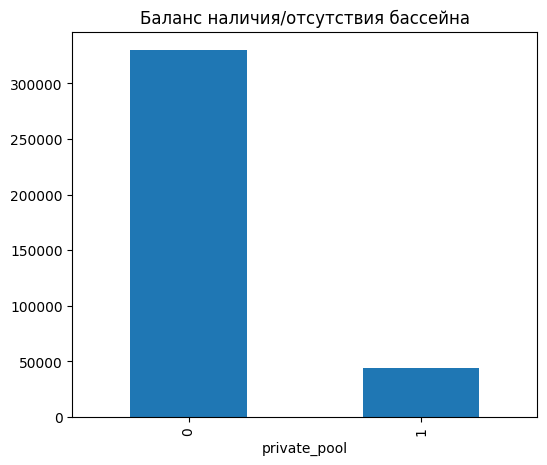

In [13]:
plt.figure(figsize=(6, 5))
private_pool.value_counts().plot(kind='bar')

plt.title('Баланс наличия/отсутствия бассейна')
plt.show()

* #### Признак `propertyType`
> Так как тут одно значение может содержать в себе множество обозначений, каждое из которых может стать отдельным dummy-cтолбцом, придется "доставать" их (обозначения) почти вручную.

In [14]:
# заменяем пропуски строками и все значенияя приводим к нижнему регистру для удобства при будущем преобразовании
realty_data['propertyType'] = realty_data['propertyType'].apply(lambda x: 'unknown' if x is np.nan else x.lower())

# синонимические ряды
categories = {'single_family': ['single-family home', 'single family', 'single family home',                        # (1) дом для одной семьи.
              'single detached, traditional', 'single detached, southwestern', 'single detached'],
              'condominium': ['coop', 'cooperative', 'condo', 'condominium'],                                       # (2) для совместного владения.
              'lot_or_land': ['lot/land', 'land', 'lot'],                                                           # (3) участок без постройки.
              'multi_family': ['multi-family', 'multi family', 'multi-family home'],                                # (4) дом больше чем для одной семьи.
              'farm': ['farm', 'ranch'],                                                                            # (5) ферма.
              'manufactured': ['manufactured', 'mfd']}                                                              # (6) собственноручно построенный дом.

# функции для извлечения обозначений по синонимам
def is_single_family(string):
    for value in categories['single_family']:
        if value in string:
            return 1
    return 0


def is_multi_family(string):
    for value in categories['multi_family']:
        if value in string:
            return 1
    return 0


def is_condo(string):
    for value in categories['condominium']:
        if value in string:
            return 1
    return 0


def is_land(string):
    for value in categories['lot_or_land']:
        if value in string:
            return 1
    return 0


def is_farm(string):
    for value in categories['farm']:
        if value in string:
            return 1
    return 0


def is_manufactured(string):
    for value in categories['manufactured']:
        if value in string:
            return 1
    return 0


# кодируем dummy-переменные
single_family = realty_data['propertyType'].apply(is_single_family)
single_family.name = 'single_family'
multi_family = realty_data['propertyType'].apply(is_multi_family)
multi_family.name = 'multi_family'
condo = realty_data['propertyType'].apply(is_condo)
condo.name = 'condo'
land = realty_data['propertyType'].apply(is_land)
land.name = 'land'
farm = realty_data['propertyType'].apply(is_farm)
farm.name = 'farm'
manufactured = realty_data['propertyType'].apply(is_manufactured)
manufactured.name = 'manufactured'
townhouse = realty_data['propertyType'].apply(lambda x: 1 if 'townhouse' in x else 0)                                   # (7) таунхаус.
townhouse.name = 'townhouse'
lake = realty_data['propertyType'].apply(lambda x: 1 if 'lake' in x else 0)                                             # (8) дом у озера.
lake.name = 'lake'
bungalow = realty_data['propertyType'].apply(lambda x: 1 if 'bungalow' in x else 0)                                     # (9) бунгало
bungalow.name = 'bungalow'
colonial = realty_data['propertyType'].apply(lambda x: 1 if 'colonial' in x else 0)                                     # (10) колониальный.
colonial.name = 'colonial'
traditional = realty_data['propertyType'].apply(lambda x: 1 if 'traditional' in x else 0)                               # (11) традиционный.
traditional.name = 'traditional'

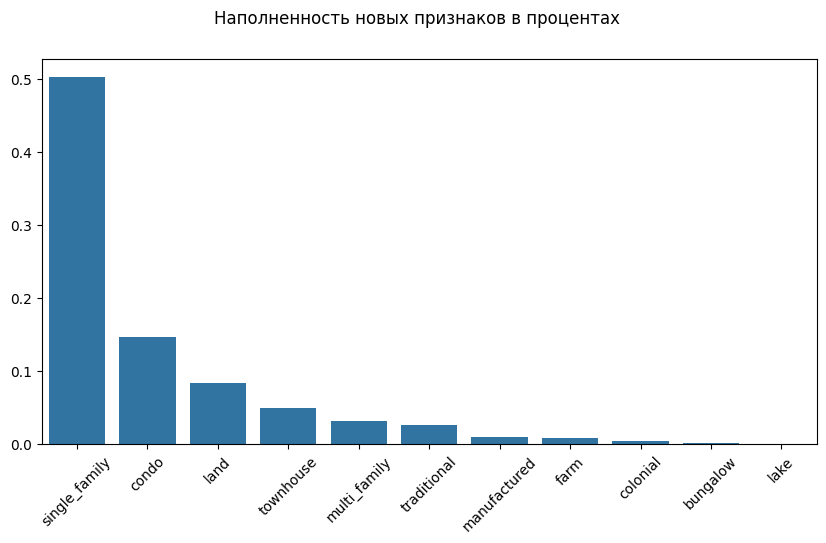

In [15]:
# визулизируем количество значений, которые говорят о наличии типа (1), для каждого из новых признаков

dummies = [single_family, multi_family, condo, land, farm, manufactured, townhouse, lake, bungalow, colonial, traditional]
keys = ['single_family', 'multi_family', 'condo', 'land', 'farm', 'manufactured', 'townhouse', 'lake', 'bungalow', 'colonial', 'traditional']
counts = {}

for key, dummy in zip(keys, dummies):
    counts[key] = dummy.value_counts(normalize=True).loc[1]

plt.figure(figsize=(10, 5))
sns.barplot(pd.Series(counts).sort_values(ascending=False))
plt.suptitle('Наполненность новых признаков в процентах')
plt.xticks(rotation=45)
plt.show()

> Также из признака `propertyType` можно извлечь данные о новизне постройки и сопоставить их со значениями с тем же смыслом из признака `status`. Аналогичная ситуация со значениями о количестве этажей. Сейчас закодируем получившиеся категории и создадим еще один новый признак `new`.

In [16]:
# кодируем признаки
contemporary = realty_data['propertyType'].apply(lambda x: 1 if 'contemporary' in x else np.nan)      
statuses['new'] = contemporary.fillna(statuses['new'])

* #### Признак `street`
> Данный признак я считаю бесполезным, так как извлечь из него какую-то информацию довольно сложно, и у нас "на руках" уже есть признаки `city` и `zipcode`.
* #### Признак `baths`
> Данный признак содержит в себе значения типа *float*, оставим их таковыми, так как они свидетельствуют не только о наличии и количестве ванных комнат, но и о наличии соответственных предметов в них. Вместо пропусков вернем единицы, так как в худшем случае в доме лишь 1 ванна.

In [17]:
def get_baths_count(baths):
    if isinstance(baths, str):
        # для удобства приведем значение к нижнему регистру
        baths = baths.lower()
        
        if baths.split(sep='.')[0].isnumeric():
            return int(baths.split(sep='.')[0])
        # обычно такие значения четырехзначные и означают площадь
        elif baths.split(sep=',')[0].isnumeric():       
            return 0
        elif baths.split()[0]=='bathrooms':
            return float(baths.split(sep=':')[1])
    else:
        return baths
    
baths = realty_data['baths'].apply(get_baths_count).fillna(1)

> Установим порог в 8 ванн, так как это наиболее большое число, которое имеет более 1000 значений. Те, что больше, - имеют значения в разы меньше.

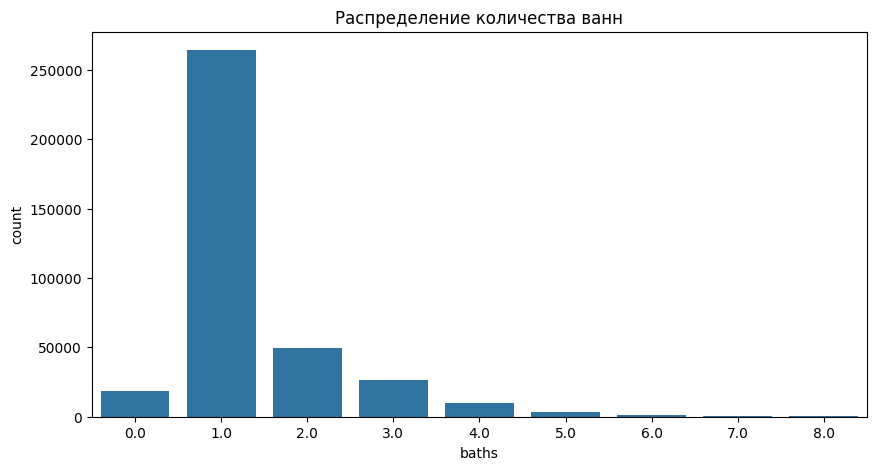

In [18]:
baths = baths.apply(lambda x: 1 if x > 8 else x)

plt.figure(figsize=(10, 5))
sns.barplot(baths.value_counts())

plt.title('Распределение количества ванн')
plt.show()

> Кажется, что чем больше ванн в помещении - тем менее популярно такое значение. К сожалению, огромное количество пропусков скорее всего искажают картину.

* #### Признак `homeFacts`
> Каждое значение в нем состоит из словаря из словарей, то есть можно данный признак преобразовать в целый датафрейм.


In [19]:
home_facts = realty_data['homeFacts'].str.replace("''", "None")
home_facts = home_facts.str.replace("'No Data'", "None")
home_facts = home_facts.apply(lambda x: ast.literal_eval(x)['atAGlanceFacts'])

facts_list = []

for fact in home_facts:
    new_dict = {}
    
    for fact_dict in fact:
        dict_values = list(fact_dict.values())
        
        new_dict[dict_values[1]] = dict_values[0]
        
    facts_list.append(new_dict)

home_facts = pd.DataFrame(facts_list)
home_facts.shape[0]

374223

In [20]:
# общая информация о новых данных
home_facts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374223 entries, 0 to 374222
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   Year built      311025 non-null  object
 1   Remodeled year  149833 non-null  object
 2   Heating         257451 non-null  object
 3   Cooling         241215 non-null  object
 4   Parking         186955 non-null  object
 5   lotsize         308275 non-null  object
 6   Price/sqft      311820 non-null  object
dtypes: object(7)
memory usage: 20.0+ MB


> Новые признаки также нуждаются в обработке.
* Признак `Year built`
> Год можно преобразовать в количество лет прошедших после постройки. Тут присутствуют значения равные 1, 2025 и несоизмеримо больше, это выбросы, заменим их на пропуски. За точку отсчета возьмем текущий год.

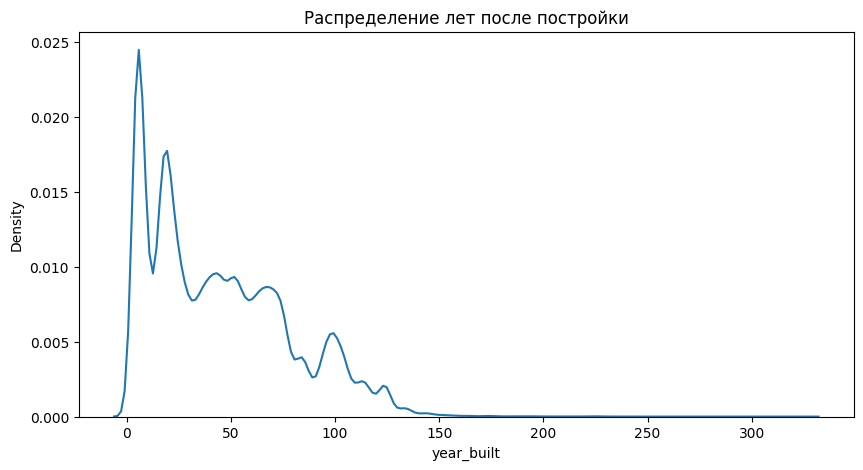

In [21]:
def get_years_count(year):            # функция для счета количества лет после построки или ремонта
    current_year = dt.now().year
    if year is None:
        return np.nan
    year = float(year)
    if year>current_year:
        return np.nan
    elif year==1:
        return np.nan
    elif year==0:
        return np.nan
    return current_year-year

year_built = home_facts['Year built'].apply(get_years_count)
year_built.name = 'year_built'

# визуализируем результат
plt.figure(figsize=(10, 5))
# удалим выбросы позже, а пока сделаем вид, что их нет для наглядности визуализации
sns.kdeplot(year_built.apply(lambda x: x if x<800 else None))

plt.title('Распределение лет после постройки')
plt.show()

> Данное распределение похоже на экспоненциальное.
* Признак `Remodeled year`
> Данный признак можно закодировать аналогичным образом.

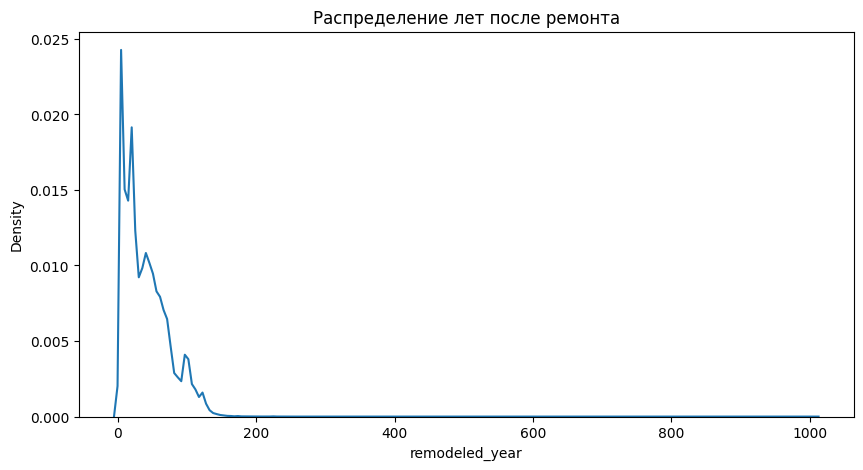

In [22]:
remodeled_year = home_facts['Remodeled year'].apply(get_years_count)
# некоторые пропуски можно заменить годом постройки
remodeled_year.fillna(year_built, inplace=True)
remodeled_year.name = 'remodeled_year'

# визуализируем результат
plt.figure(figsize=(10, 5))
sns.kdeplot(remodeled_year)

plt.title('Распределение лет после ремонта')
plt.show()

> Данные распределены ненормально. Стоит проверить, соотносится ли этот признак с предыдущим, ведь кол-во прошедших лет после ремонта не могут превышать кол-во лет после постройки.

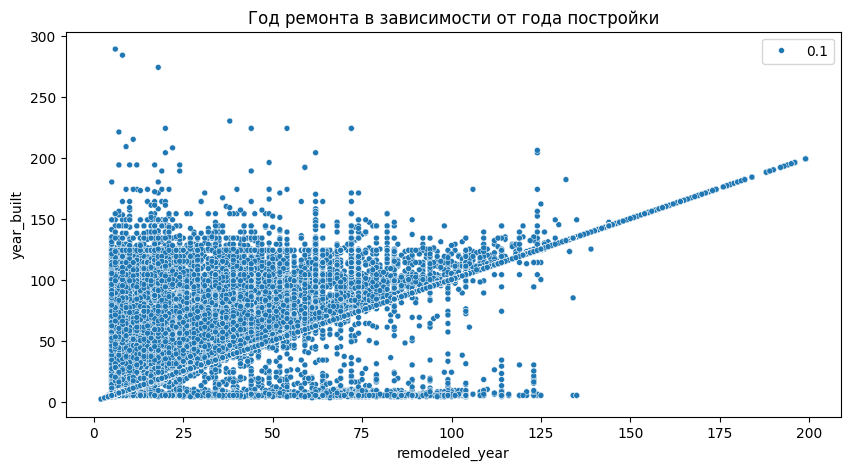

In [23]:
plt.figure(figsize=(10, 5))
# удалим выбросы позже, а пока сделаем вид, что их нет для наглядности визуализации
sns.scatterplot(x=remodeled_year[remodeled_year<200], y=year_built[year_built<400], size=0.1)

plt.title('Год ремонта в зависимости от года постройки')
plt.show()

> Мне неизвестно, с чем связано наличие странных значений. Поэтому после соединения всех закодированых столбцов я удалю строки, в которых количество лет после ремонта превышает количество лет после постройки.
* Признаки `Heating` и `Cooling`
> Часто обогреватели могут охлаждать (кондиционеры), и одно значение может содержать в себе несколько разных обозначений, для каждого из которых может существовать отдельный столбец. Поэтому я считаю целесообразным cовмещать данные из обоих признаков. То есть, по ключевым словам изымать значения и там и там для одних и тех же dummy-переменных. К тому же, таким образом получится уменьшить количество пропусков для будущих признаков.

In [24]:
# заменяем пропуски строками и все значенияя приводим к нижнему регистру для удобства при будущем преобразовании
home_facts['Heating'] = home_facts['Heating'].apply(lambda x: 'unknown' if x is None else x.lower())
home_facts['Cooling'] = home_facts['Cooling'].apply(lambda x: 'unknown' if x is None else x.lower()) 

In [25]:
# инициализируем dummy-переменные
forced_air = home_facts['Heating'].apply(lambda x: 1 if 'forced' in x else 0)
forced_air_cool = home_facts['Cooling'].apply(lambda x: 1 if 'forced' in x else 0)

heat_pump = home_facts['Heating'].apply(lambda x: 1 if 'heat pump' in x else 0)
heat_pump_cool = home_facts['Cooling'].apply(lambda x: 1 if 'heat pump' in x else 0)

gas = home_facts['Heating'].apply(lambda x: 1 if 'gas' in x else 0)
gas_cool = home_facts['Cooling'].apply(lambda x: 1 if 'gas' in x else 0)

central_heat = home_facts['Heating'].apply(lambda x: 1 if 'central heat' in x else 0)
central_heat_cool = home_facts['Cooling'].apply(lambda x: 1 if 'central heat' in x else 0)

central_cool = home_facts['Heating'].apply(lambda x: 1 if 'central cool' in x else 0)
central_cool_cool = home_facts['Cooling'].apply(lambda x: 1 if 'central cool' in x else 0)

central_air = home_facts['Heating'].apply(lambda x: 1 if 'central a' in x else 0)
central_air_cool = home_facts['Cooling'].apply(lambda x: 1 if 'central a' in x else 0)

hot_water = home_facts['Heating'].apply(lambda x: 1 if 'hot water' in x else 0)
hot_water_cool = home_facts['Cooling'].apply(lambda x: 1 if 'hot water' in x else 0)

baseboard = home_facts['Heating'].apply(lambda x: 1 if ('baseboard' or 'floor') in x else 0)
baseboard_cool = home_facts['Cooling'].apply(lambda x: 1 if ('baseboard' or 'floor') in x else 0)

radiator = home_facts['Heating'].apply(lambda x: 1 if 'radiator' in x else 0)
radiator_cool = home_facts['Cooling'].apply(lambda x: 1 if 'radiator' in x else 0)

# таких значений в столбце `Cooling` нет
wall = home_facts['Heating'].apply(lambda x: 1 if 'wall' in x else 0)
wall_cool = home_facts['Cooling'].apply(lambda x: 1 if 'wall' in x else 0)

In [26]:
features = [forced_air, heat_pump, gas, central_heat, central_cool, central_air, hot_water, baseboard, radiator, wall]
features_cool = [forced_air_cool, heat_pump_cool, gas_cool, central_heat_cool, central_cool_cool, central_air_cool, hot_water_cool, 
                 baseboard_cool, radiator_cool, wall_cool]
features_names = ['forced_air', 'heat_pump', 'gas', 'central_heat', 'central_cool', 'central_air', 'hot_water', 'baseboard', 'radiator', 'wall']

for feature, feature_cool, feature_name in zip(features, features_cool, features_names):
    feature.fillna(feature_cool, inplace=True)
    feature.name = feature_name


* Признак `Parking`
> Аналогично признаку выше выделим типы парковки, создадим отдельный признак для количества мест для парковки.

In [27]:
# заменяем пропуски строками и все значенияя приводим к нижнему регистру для удобства при будущем преобразовании
home_facts['Parking'] = home_facts['Parking'].apply(lambda x: 'unknown' if x is None else x.lower())

In [28]:
# кодируем dummy-переменые
attached_garage = home_facts['Parking'].apply(lambda x: 1 if 'attached' in x else 0)
attached_garage.name = 'attached_garage'
detached_garage = home_facts['Parking'].apply(lambda x: 1 if 'detached' in x else 0)
detached_garage.name= 'detached_garage'
paved_parking = home_facts['Parking'].apply(lambda x: 1 if 'paved' in x else 0)
paved_parking.name = 'paved_parking'
garage = home_facts['Parking'].apply(lambda x: 1 if 'garage' in x else 0)
garage.name = 'garage'
auto_door = home_facts['Parking'].apply(lambda x: 1 if 'auto' in x else 0)
auto_door.name = 'auto_door'
common = home_facts['Parking'].apply(lambda x: 1 if 'common' in x else 0)
common.name = 'common'
is_secure = home_facts['Parking'].apply(lambda x: 1 if 'secure' in x else 0)
is_secure.name = 'is_secure' 
carport = home_facts['Parking'].apply(lambda x: 1 if 'carport' in x else 0)
carport.name = 'carport'

In [29]:
# создаем признак с количеством парковочных мест
def get_spaces_count(string):                                         # функция для подсчета парковочных мест
    for value in string:
        if value.isnumeric():
            if len(string.split())==1:
                return float(string)
            elif 'space' in string:
                return int(value)
            elif 'car'in string:
                return int(value)
    if string!='unknown':
        return 1
    return 0
                
parking_spaces_cnt = home_facts['Parking'].apply(get_spaces_count)
parking_spaces_cnt.name = 'parking_spaces_cnt'

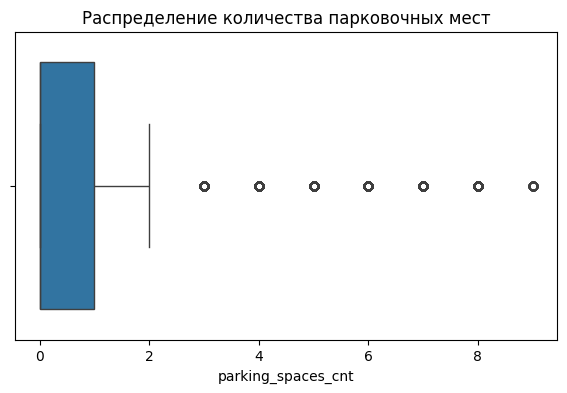

In [30]:
# визуализируем результат
plt.figure(figsize=(7, 4))
# удалим выбросы позже, а пока сделаем вид, что их нет для наглядности визуализации
sns.boxplot(parking_spaces_cnt.apply(lambda x: x if x<10 else None),
            orient='h')

plt.title('Распределение количества парковочных мест')
plt.show()

* Признаки `lotsize` и `Price/sqft`
> Из данных признаков можно извлечь не только соответственные числовые значения, но и создать признак, который будет означать цену за участок.

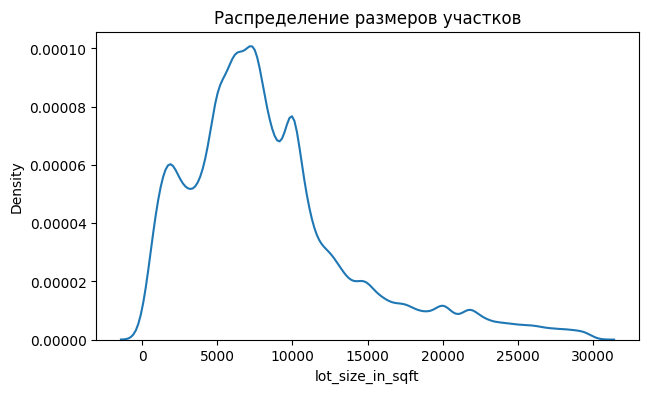

In [31]:
# обрабатываем признак lotsize

def lot_size_sqrt(value):
    if value is not None:
        value = value.lower()
        
        if 'sq' in value:
            if ',' in value:
                return int(value.split()[0].replace(',', ''))
            if '--' in value:
                return np.nan
            return int(value.split()[0])
        elif value.split(sep='.')[0]=='0':
            return float(value.split()[0])*43560
        elif value.isnumeric():
            return int(value)
        return np.nan
    
    return np.nan

lot_size_in_sqft = home_facts['lotsize'].apply(lot_size_sqrt)
lot_size_in_sqft.name = 'lot_size_in_sqft'

# визуализируем распределение закодированого признака
plt.figure(figsize=(7, 4))
# удалим выбросы позже, а пока сделаем вид, что их нет для наглядности визуализации
sns.kdeplot(lot_size_in_sqft[lot_size_in_sqft<3e4])
plt.title('Распределение размеров участков')
plt.show()

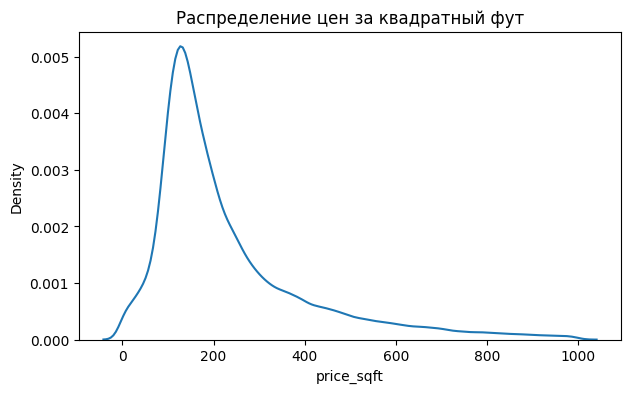

In [32]:
# обрабатываем признак Price/sqft

def get_price_sqft(price):
    if price is not None:
        if price=='No Info':
            return np.nan
        elif price=='Contact manager':
            return np.nan
        return int(price.replace('$', '').replace('/sqft', '').replace(' / Sq. Ft.', '').replace(',', ''))
    return np.nan 

price_sqft = home_facts['Price/sqft'].apply(get_price_sqft)

price_sqft.name = 'price_sqft'

# визуализируем распределение закодированого признака
plt.figure(figsize=(7, 4))
# удалим выбросы позже, а пока сделаем вид, что их нет для наглядности визуализации
sns.kdeplot(price_sqft[price_sqft<1000])
plt.title('Распределение цен за квадратный фут')
plt.show()

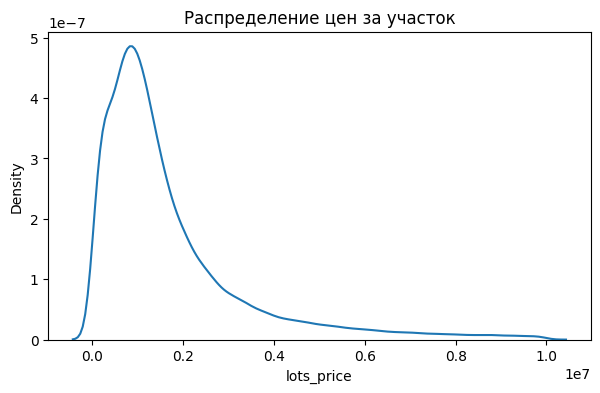

In [33]:
# создаем признак lots_price
lots_price = lot_size_in_sqft*price_sqft
lots_price.name = 'lots_price'

# визуализируем распределение закодированого признака
plt.figure(figsize=(7, 4))
# удалим выбросы позже, а пока сделаем вид, что их нет для наглядности визуализации
sns.kdeplot(lots_price[lots_price<1e7])
plt.title('Распределение цен за участок')
plt.show()

> Распределения данных признаков похожи на нормальные с положительной асимметрией.

* #### Признак `fireplace`
> Данный признак содержит в себе очень много общих обозначений с признаками `Heating` и `Cooling`, поэтому стоит их сопоставить и дополнить уже существующие dummy-переменные. А также выделим значения, характерные только для этого признака.

In [34]:
realty_data['fireplace'] = realty_data['fireplace'].apply(lambda x: 'unknown' if x is np.nan else x.lower())

In [35]:
# сопоставляем значения с уже существующими dummy-переменными
hot_water_fp = realty_data['fireplace'].apply(lambda x: 1 if 'hot water' in x else 0)
baseboard_fp = realty_data['fireplace'].apply(lambda x: 1 if 'baseboard' in x else 0)
radiator_fp = realty_data['fireplace'].apply(lambda x: 1 if 'radiator' in x else 0)
forced_air_fp = realty_data['fireplace'].apply(lambda x: 1 if 'forced' in x else 0)
gas_fp = realty_data['fireplace'].apply(lambda x: 1 if 'gas' in x else 0)

features = [forced_air, gas, hot_water, baseboard, radiator]
features_fp = [forced_air_fp, gas_fp, hot_water_fp, baseboard_fp, radiator_fp]

for feature, feature_fp in zip(features, features_fp):
    feature.fillna(feature_cool, inplace=True)

In [36]:
# создаем новые dummy-переменные
family_room = realty_data['fireplace'].apply(lambda x: 1 if 'family' in x else 0)
family_room.name = 'family_room'
living_room = realty_data['fireplace'].apply(lambda x: 1 if 'living' in x else 0)
living_room.name = 'living_room'
great_room = realty_data['fireplace'].apply(lambda x: 1 if 'great' in x else 0)
great_room.name = 'great_room'
wood_burning = realty_data['fireplace'].apply(lambda x: 1 if 'wood' in x else 0)
wood_burning.name = 'wood_burning'
walk_in_closets = realty_data['fireplace'].apply(lambda x: 1 if 'walk' in x else 0)
walk_in_closets.name = 'walk_in_closets'
utility_connection = realty_data['fireplace'].apply(lambda x: 1 if 'utility' in x else 0)
utility_connection.name = 'utility_connection'
ceiling_fan = realty_data['fireplace'].apply(lambda x: 1 if 'ceiling' in x else 0)
ceiling_fan.name = 'ceiling_fan'
storage = realty_data['fireplace'].apply(lambda x: 1 if 'storage' in x else 0)
storage.name = 'storage'

* #### Признаки `city` и `state`
> Сам по себе признаки малоинформативный, но можно обратиться за данными к сторонним источникам. Я нашла датасет с городами Соединенных Штатов и актуальными данными о продаже недвижимости (https://simplemaps.com/data/us-cities).

In [37]:
cities_data = pd.read_csv('data/simplemaps_uscities_basicv1.78.zip')

> Из данной таблицы я выбераю схожие по смыслу столбцы: `population`, `density` и `ranking`.

In [38]:
realty_data['city'] = realty_data['city'].str.lower()
cities_data['city'] = cities_data['city'].str.lower()

In [39]:
cities_dups = cities_data[cities_data[['city', 'state_id']].duplicated()].index 
cities_data.drop(cities_dups, axis=0, inplace=True)

In [40]:
# соединяем данные
cities_data.rename(columns={'state_id': 'state'}, inplace=True)

cities_data = pd.merge(realty_data[['city', 'state']],
                       cities_data[['city', 'state', 'population', 'density', 'ranking']],
                       how='left',
                       on=['city', 'state'])

# заполняем пропуски средним значением
cities_data.fillna(
    {'population': cities_data['population'].median(), 
     'density': cities_data['density'].median(), 
     'ranking': cities_data['ranking'].mode()[0]},
    inplace=True
)

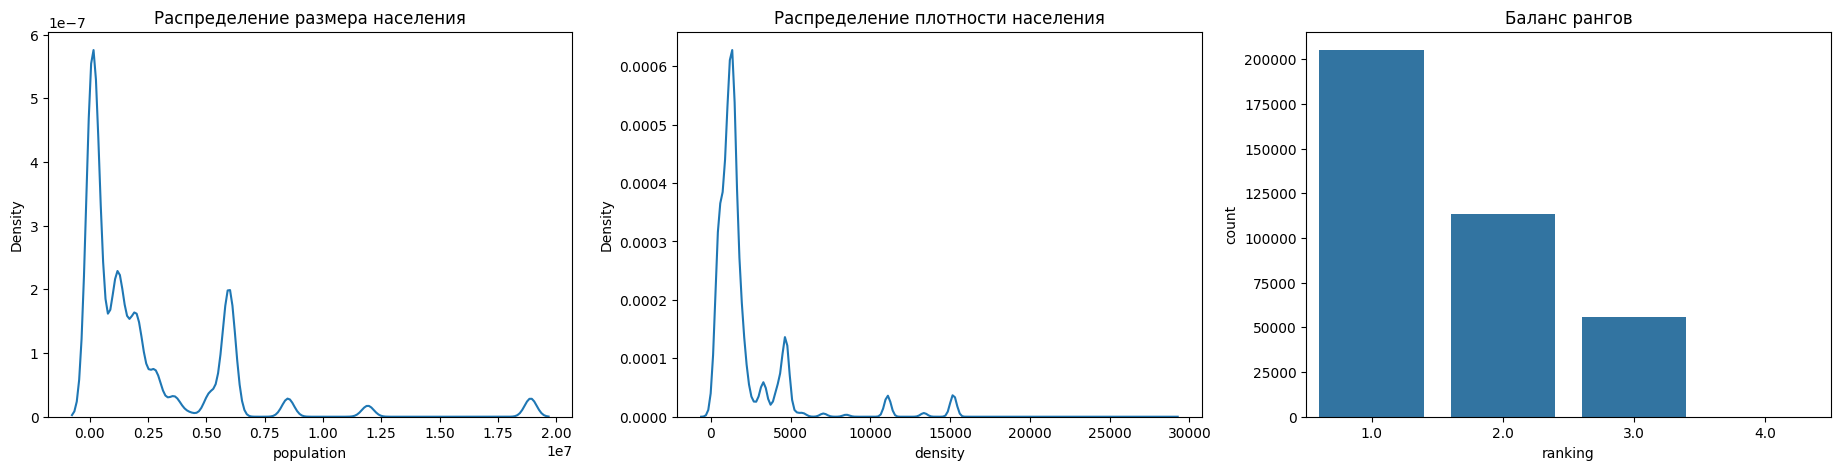

In [41]:
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(23, 5))

sns.kdeplot(cities_data['population'], ax=axes[0])
axes[0].set_title('Распределение размера населения')

sns.kdeplot(cities_data['density'], ax=axes[1])
axes[1].set_title('Распределение плотности населения')

ranking_count = cities_data['ranking'].value_counts()
sns.barplot(ranking_count, ax=axes[2])
axes[2].set_title('Баланс рангов')

fig.show()

> Значения равные 4 во столбце `ranking` вероятнее всего являются выбросами. Далее посмотрим на количества значений признаков `city` и `state` и примем решение, нужны ли отдельные столбцы для конкретных городов или штатов.

In [42]:
print(cities_data['city'].value_counts(normalize=True),
      cities_data['state'].value_counts(normalize=True))

city
houston          0.065167
san antonio      0.041408
miami            0.041123
jacksonville     0.026474
dallas           0.023384
                   ...   
langley          0.000003
newport beach    0.000003
sherman vlg      0.000003
lily dale        0.000003
blue springs     0.000003
Name: proportion, Length: 1904, dtype: float64 state
FL    0.306047
TX    0.222477
NY    0.065001
CA    0.061912
NC    0.058147
TN    0.048680
WA    0.036673
OH    0.033194
IL    0.023574
NV    0.022452
GA    0.017711
CO    0.017025
PA    0.014678
MI    0.013679
DC    0.012239
AZ    0.008944
IN    0.008762
OR    0.007413
MA    0.003990
UT    0.003525
MD    0.002902
VT    0.002309
MO    0.002223
VA    0.002138
WI    0.001208
NJ    0.001165
ME    0.000689
IA    0.000647
KY    0.000240
OK    0.000131
MS    0.000104
SC    0.000075
MT    0.000019
DE    0.000013
Fl    0.000003
BA    0.000003
AL    0.000003
OT    0.000003
OS    0.000003
Name: proportion, dtype: float64


> Столбец `city` не нуждается в кодировке, так каждое значение занимает не более 6% в данных. А вот `state` имеет 2 значения, у которых большой процентный разрыв с остальными, - штаты FL и TX. Для них и создадим две дополнительные dummy-переменные, а оставшиеся столбцы с городами и штатами удалим.

In [43]:
cities_data['is_FL'] = cities_data['state'].apply(lambda x: 1 if x=='FL' else 0)
cities_data['is_TX'] = cities_data['state'].apply(lambda x: 1 if x=='TX' else 0)
cities_data.drop(['city', 'state'], axis=1, inplace=True)

* #### Признак `schools`
> В данном признаке значения закодированы аналогично признаку `homeFacts`. Соответственно, сначала извлечем из него новый датафрейм и уже затем обработаем его.

In [44]:
def get_schools_dict(x):
    x_dict = ast.literal_eval(x)[0]
    
    x_dict['distance'] = x_dict['data']['Distance']
    x_dict['grades'] = x_dict['data']['Grades']
    
    del x_dict['data']
    
    return x_dict
    

schools_data = realty_data['schools'].apply(get_schools_dict)
schools_data = pd.DataFrame(schools_data.tolist())

In [45]:
# посмотрим общую информацию о новых данных
schools_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374223 entries, 0 to 374222
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   rating    374223 non-null  object
 1   name      374223 non-null  object
 2   distance  374223 non-null  object
 3   grades    374223 non-null  object
dtypes: object(4)
memory usage: 11.4+ MB


* Признак `ratings`
> Данный признак содержит в себе рейтинги нескольких школ (еще и уникальных вероятно практически для всех домов). Выделим из него два признака: сумма и среднее рейтингов.

In [46]:
def get_school_ratings(x):
    x_new = []
    
    for rating in x:
        rating = (rating
                  .replace('/10', '')
                  .replace('NR', '1')
                  .replace('NA', '1')
                  .replace('None', '1'))
        
        if rating == '':
            rating = '1'
        
        x_new.append(int(rating))
        
    return np.array(x_new)


school_ratings = schools_data['rating'].apply(get_school_ratings) 

school_ratings_sum = school_ratings.apply(lambda x: x.sum())
school_ratings_sum.name = 'school_ratings_sum'

school_ratings_mean = school_ratings.apply(lambda x: x.mean())
school_ratings_mean.fillna(0, inplace=True)
school_ratings_mean.name = 'school_ratings_mean'

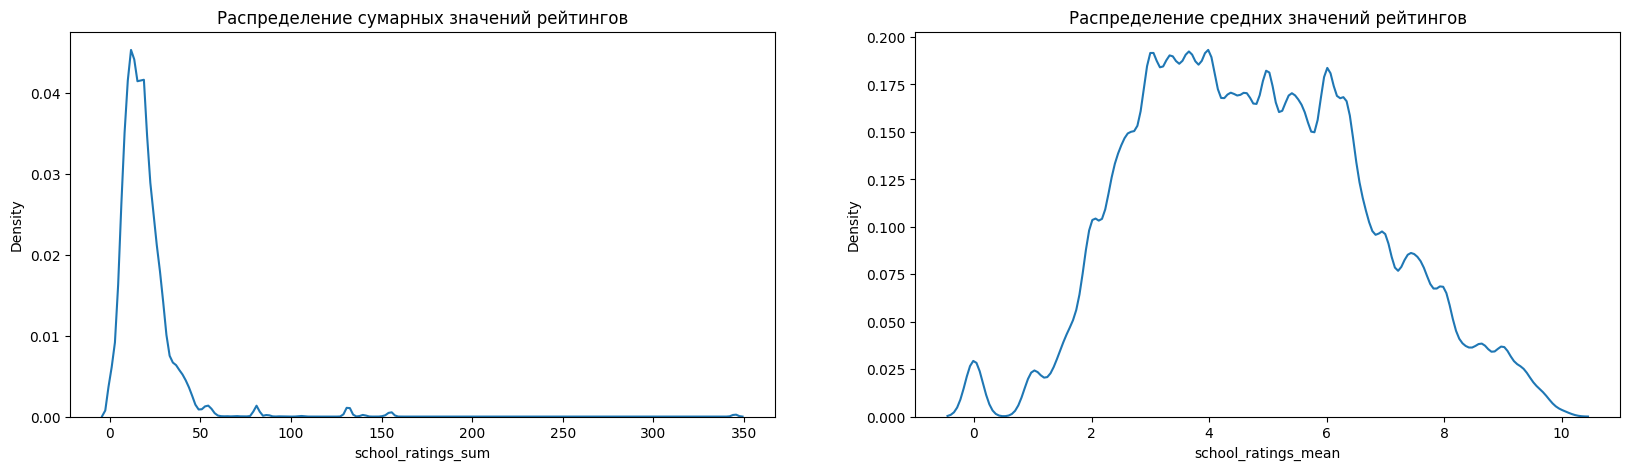

In [47]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5))

sns.kdeplot(school_ratings_sum, ax=axes[0])
axes[0].set_title('Распределение сумарных значений рейтингов')

sns.kdeplot(school_ratings_mean, ax=axes[1])
axes[1].set_title('Распределение средних значений рейтингов')

fig.show()

> Первый график показывает наличие выбросов, а второй - распределение, которое потенциально можно преобразовать в нормальное.
* Признак `distance`
> Из данного признака можно извлечь среднее растояние и растояние до ближайшей школы.

In [48]:
def get_school_distances(x):
    if len(x) == 0:
        return np.nan
    
    x_new = []
     
    for distance in x:
        distance = (distance
                    .replace(' ', '')
                    .replace('mi', ''))
        
        x_new.append(float(distance))
        
    return np.array(x_new)


school_distances = schools_data['distance'].apply(get_school_distances)

school_distance_nearest = school_distances.apply(lambda x: x.min() if x is not np.nan else x)
school_distance_nearest.fillna(school_distance_nearest.median(), inplace=True)
school_distance_nearest.name = 'school_distance_nearest'

school_distance_mean = school_distances.apply(lambda x: x.mean() if x is not np.nan else x)
school_distance_mean.fillna(school_distance_mean.median(), inplace=True)
school_distance_mean.name = 'school_distance_mean'

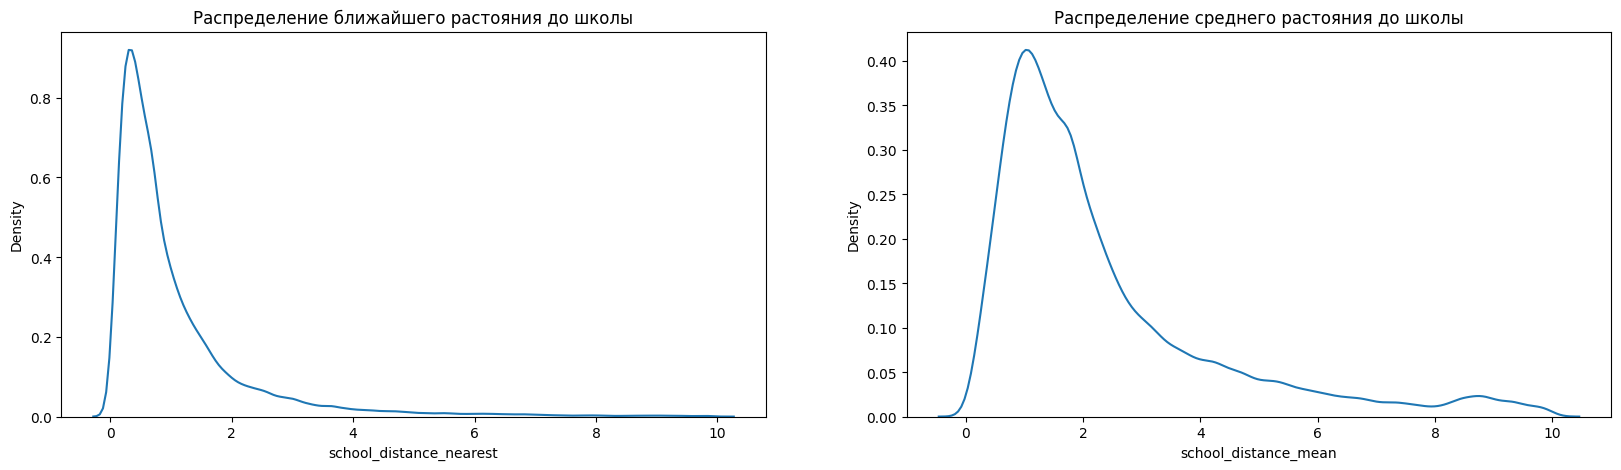

In [49]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5))

# сделаем вид, будто выбросы отсутствуют, удалим их позже
sns.kdeplot(school_distance_nearest[school_distance_nearest<10], ax=axes[0])
axes[0].set_title('Распределение ближайшего растояния до школы')

sns.kdeplot(school_distance_mean[school_distance_mean<10], ax=axes[1])
axes[1].set_title('Распределение среднего растояния до школы')

fig.show()

> Данные распределения похожи на нормальные с положительной асимметрией.
* Признак `grades`
> Тут извлечем количество уникальных классов, которые можно окончить в районе купленной недвижимости.

In [50]:
def get_school_grades(x):
    x_new = []
    
    for grade in x:
        if grade is None:
            grade = '0'
            
        if ',' in grade:
            x_new.extend(grade.split(', '))
        else:
            x_new.append(grade)
    
    x_new_2 = []
    
    for grade in x_new:
        grade = grade.lower()
        
        grade = (grade
                 .replace(' to ', '-')
                 .replace('–', '-')
                 .replace('n/a', '0')
                 .replace('na', '0')
                 .replace('preschool', '0')
                 .replace('pk', '0')
                 .replace('k', '0'))
                        
        if '-' in grade:
            g_split = grade.split('-')
            
            if g_split[0] == g_split[1]:
                grade = g_split[0]
                
            for int_grade in range(int(g_split[0]), int(g_split[1])+1):
                x_new_2.append(int_grade)
        
        else:
            x_new_2.append(int(grade))
        
    return len(set(x_new_2))


school_grades = schools_data['grades'].apply(get_school_grades)
school_grades.name = 'school_grades'

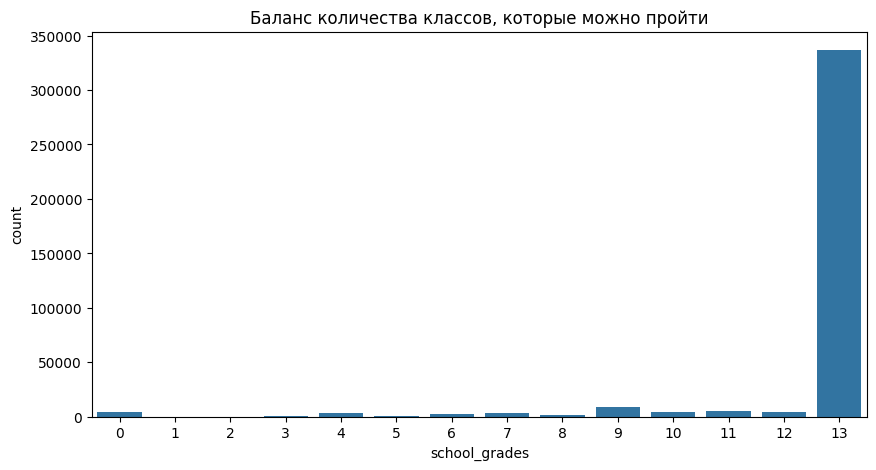

In [51]:
plt.figure(figsize=(10, 5))
sns.barplot(school_grades.value_counts())
plt.title('Баланс количества классов, которые можно пройти')
plt.show()

> Как видим, практически везде можно пройти полный курс образования: от садика до старшей школы.
* #### Признак `sqft`
> Это размер непосредственно помещения. После перекодировки стоит проверить, есть ли значения больше, чем размер всего участка.

In [52]:
def get_sqfts(value):
    if ((value is np.nan) or
        ('-' in value) or
        (value == '0')):
        return np.nan
    
    else:
        value = (value
                 .replace(' sqft', '')
                 .replace(',', '')
                 .replace('Total interior livable area: ', ''))
        
        return int(value)

area_in_sqft = realty_data['sqft'].apply(get_sqfts)
# заполняем пропуски средним значением
area_in_sqft.fillna(int(area_in_sqft.median()), inplace=True)
area_in_sqft.name = 'area_in_sqft'

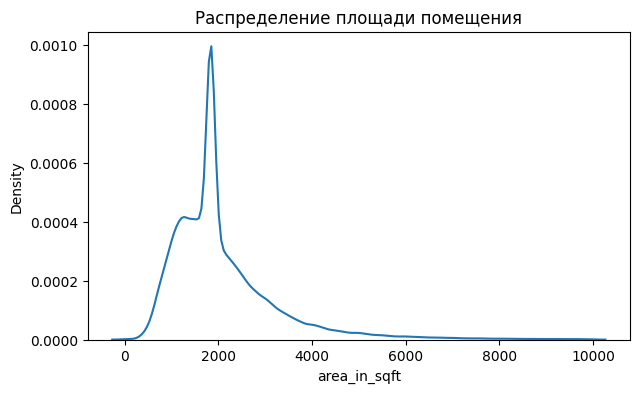

In [53]:
# визуализируем распределение закодированого признака
plt.figure(figsize=(7, 4))
# удалим выбросы позже, а пока сделаем вид, что их нет для наглядности визуализации
sns.kdeplot(area_in_sqft[area_in_sqft<10000])
plt.title('Распределение площади помещения') 
plt.show() 

> Данное распределение похоже на нормальное с положительной асимметрией.
* #### Признак `zipcode`
> В данном признаке закодированы три значения: первая цифра - группа штата; следущие две цифры - район штата; последние две цифры - район города. После того как мы их выделим, нужно создать для них dummy-переменные, так как эти значения не порядковые.

In [54]:
def get_zipcode(value):
    if len(value) >= 5:
        return value[:5]
    else:
        return '00000'

zipcode = realty_data['zipcode'].apply(get_zipcode)

bin_encoder = ce.BinaryEncoder()
zipcode = bin_encoder.fit_transform(zipcode)

zipcode

,zipcode_0,zipcode_1,zipcode_2,zipcode_3,zipcode_4,zipcode_5,zipcode_6,zipcode_7,zipcode_8,zipcode_9,zipcode_10,zipcode_11,zipcode_12
0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,0,1,1
3,0,0,0,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
374218,0,0,0,1,0,1,0,1,1,1,0,1,1
374219,0,0,0,0,1,0,0,0,1,1,0,1,0
374220,0,0,0,0,1,1,0,1,0,0,1,1,1
374221,0,0,0,0,1,1,1,0,1,0,0,1,0


* #### Признак `beds` 
> Выделяем кол-во кроватей.

In [55]:
def get_beds_count(value):
    if (value is np.nan) or (value == ' '):
        return 1
    
    for error in ['sqft', 'acre', '$', '#']:
        if error in value.lower():
            return 0
    
    if 'Bedrooms' in value:
        value_splitted = value.split(',')
        
        for word in value_splitted:
            if 'Bedrooms' in word:
                return int(word.split()[0])
    
    else:
        value = (value
                 .replace('.0', '')
                 .replace(' Beds', '')
                 .replace(' bd', ''))
        
        if (('bath' in value.lower()) or
            ('-' in value.lower())):
                return 0
            
        return int(value)
        
beds = realty_data['beds'].apply(get_beds_count)

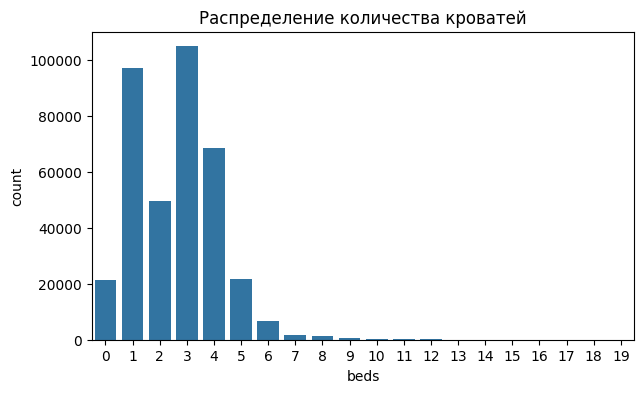

In [56]:
# визуализируем результат
plt.figure(figsize=(7, 4))
# удалим выбросы позже, а пока сделаем вид, что их нет для наглядности визуализации
beds_counts = beds[beds<20].value_counts()
sns.barplot(beds_counts)

plt.title('Распределение количества кроватей')
plt.show()

* #### Признак `stories`
> Выше было отмечено, что в признаке `propertyType` также содержатся значения с количеством этажей. А eще, данный признак содержит в себе значения, которые характерны для того же `propertyType`. Сопоставим два признака, чтобы сделать один столбец с этажами, но более наполненный. Аналогично дополним dummy-признаки, которые означают тип здания.

In [57]:
# обрабатываем исходный признак 'stories'
def get_stories_from_stories(string):
    if string is np.nan:
        return 1
    if '+' in string:
        string = string.replace('+', '')
    if '-' in string:
        for x in string.split(sep='-')[-1].split():
            if x.isnumeric():
                return int(x)
    if '.' in string:
        if string.split(sep='.')[0].isnumeric():
            return int(string.split(sep='.')[0])
    if string=='0':
        return 1
    elif string=='0.0':
        return 1
    for x in string.split():
        if x.isnumeric():
            return int(x)
    
    stories_dict = {'One': 1, 'Two': 2, 'Three': 3}
    for key in stories_dict.keys():
        if key in string:
            return stories_dict[key]
    return 1

stories = realty_data['stories'].apply(get_stories_from_stories).apply(lambda x: x if x > 0 else 1)

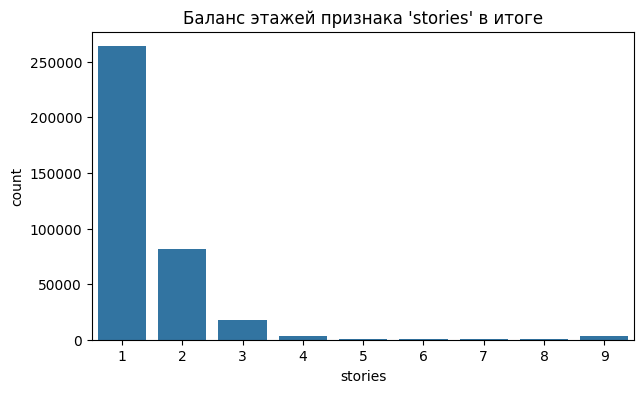

In [58]:
# изымаем значения с количеством этажей из признака 'propertyType'
def get_stories_from_pt(string):
    words_lst = string.split()
    stories_dict = {'one': 1, 'two': 2, 'three': 3}
    
    for i, value in enumerate(words_lst):
        for word in ('story', 'stories'):
            if word in value:
                if '/' in words_lst[i-1]:
                    return int(words_lst[i-1].split(sep='/')[0])
                elif '.' in words_lst[i-1]:
                    return int(words_lst[i-1].split(sep='.')[0])
                for num in stories_dict:
                    if num==words_lst[i-1]:
                        return stories_dict[num]
                if words_lst[i-1].isnumeric():
                    return int(words_lst[i-1])
    
stories_by_pt = realty_data['propertyType'].apply(get_stories_from_pt).fillna(1)

# сопоставляем оба признака
stories.fillna(stories_by_pt, inplace=True)

# визуализируем распределение закодированого признака
plt.figure(figsize=(7, 4))
stories_counts = stories[stories<10].value_counts()
sns.barplot(stories_counts)
plt.title("Баланс этажей признака 'stories' в итоге") 
plt.show() 

In [59]:
# изымаем значения для dummy-переменных и дополняем их 
realty_data['stories'] = realty_data['stories'].fillna('unknown')
realty_data['stories'] = realty_data['stories'].str.lower()

farm_by_stories = realty_data['stories'].apply(is_farm)
condo_by_stories = realty_data['stories'].apply(is_condo)
manufactured_by_stories = realty_data['stories'].apply(is_manufactured)
townhouse_by_stories = realty_data['stories'].apply(lambda x: 1 if 'townhouse' in x else 0)   
traditional_by_stories = realty_data['stories'].apply(lambda x: 1 if 'traditional' in x else 0)  
bungalow_by_stories = realty_data['stories'].apply(lambda x: 1 if 'bungalow' in x else 0)  
colonial_by_stories = realty_data['stories'].apply(lambda x: 1 if 'colonial' in x else 0)

features = [farm, condo, manufactured, townhouse, traditional, bungalow, colonial]
features_cool = [farm_by_stories, condo_by_stories, manufactured_by_stories, townhouse_by_stories, 
                 traditional_by_stories, bungalow_by_stories, colonial_by_stories]

for feature, feature_cool in zip(features, features_cool):
    feature.fillna(feature_cool, inplace=True)

* #### Признаки `mls-id` и `MlsId`
> Данные признаки можно было бы объединить аналогично признаку `private_pool` и использовать для парсинга данных, но я не нашла бесплатных источников. Поэтому этот признак игнорируем.

* #### Предобработка таргета и объединение переменных

In [60]:
realty_data['target']

0           $418,000
1           $310,000
2         $2,895,000
3         $2,395,000
4             $5,000
             ...    
374218    $1,249,000
374219      $674,999
374220      $528,000
374221       $34,500
374222      $204,900
Name: target, Length: 374223, dtype: object

In [61]:
def get_target(value):
    for symbol in ['$', ',', '+']:
        value = value.replace(symbol, '')
        
    return int(value)

# новый очищеный таргет в числовом формате
target = realty_data['target'].apply(get_target)

In [62]:
# объединим все новые признаки в новую таблицу

# список новых признаков 
features = [
    statuses, private_pool, single_family, multi_family, condo, land, farm, manufactured, townhouse, lake, bungalow, 
    colonial, traditional, baths, year_built, remodeled_year, forced_air, heat_pump, gas, central_heat, central_cool, 
    central_air, hot_water, baseboard, radiator, wall, attached_garage, detached_garage, paved_parking, garage, 
    auto_door, common, is_secure, carport, parking_spaces_cnt, family_room, living_room, great_room, wood_burning, 
    walk_in_closets, utility_connection, ceiling_fan, storage, cities_data, school_ratings_sum, school_ratings_mean, 
    school_distance_nearest, school_distance_mean, school_grades,area_in_sqft, zipcode, beds, stories, price_sqft, target
    #lot_size_in_sqft, lots_price - не берем в таблицу так как в них слишком много пропусков
]

realty_data = pd.concat(features, axis=1)

realty_data

,auction,backup,closed,contigent,foreclosed,inspection,is_active,new,option contract,pre_foreclosure,...,zipcode_7,zipcode_8,zipcode_9,zipcode_10,zipcode_11,zipcode_12,beds,stories,price_sqft,target
0,0,0,0,0,0,0,1,0.0,0,0,...,0,0,0,0,0,1,4,1,144.0,418000
1,0,0,0,0,0,0,1,0.0,0,0,...,0,0,0,0,1,0,3,2,159.0,310000
2,0,0,0,0,0,0,1,0.0,0,0,...,0,0,0,0,1,1,3,1,965.0,2895000
3,0,0,0,0,0,0,1,0.0,0,0,...,0,0,0,1,0,0,5,3,371.0,2395000
4,0,0,0,0,0,0,1,0.0,0,0,...,0,0,0,1,0,1,1,1,NaN,5000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
374218,0,0,0,0,0,0,0,0.0,0,0,...,1,1,1,0,1,1,5,1,311.0,1249000
374219,0,0,0,0,0,0,1,0.0,0,0,...,0,1,1,0,1,0,3,9,337.0,674999
374220,0,0,0,0,0,0,1,0.0,0,0,...,1,0,0,1,1,1,3,2,458.0,528000
374221,0,0,0,0,0,0,0,0.0,0,0,...,0,1,0,0,1,0,0,1,NaN,34500


* #### Очистка данных от выбросов и пропусков
> Выше было указано, что нужно удалить строки в которых год постройки больше чем год после последнего ремонта. Начнем с этого.

In [63]:
# удалим пропуски и нелогичные данные
realty_data.dropna(inplace=True)
realty_data.query('remodeled_year <= year_built', inplace=True)
realty_data.reset_index(drop=True, inplace=True)

realty_data

,auction,backup,closed,contigent,foreclosed,inspection,is_active,new,option contract,pre_foreclosure,...,zipcode_7,zipcode_8,zipcode_9,zipcode_10,zipcode_11,zipcode_12,beds,stories,price_sqft,target
0,0,0,0,0,0,0,1,0.0,0,0,...,0,0,0,0,0,1,4,1,144.0,418000
1,0,0,0,0,0,0,1,0.0,0,0,...,0,0,0,0,1,0,3,2,159.0,310000
2,0,0,0,0,0,0,1,0.0,0,0,...,0,0,0,0,1,1,3,1,965.0,2895000
3,0,0,0,0,0,0,1,0.0,0,0,...,0,0,0,1,0,0,5,3,371.0,2395000
4,0,0,0,0,0,0,1,0.0,0,0,...,0,0,0,1,1,0,2,2,233.0,209000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
288815,0,0,0,0,0,0,1,0.0,0,0,...,0,1,1,1,1,0,2,3,564.0,799000
288816,0,0,0,0,0,0,0,0.0,0,0,...,1,1,1,0,1,1,5,1,311.0,1249000
288817,0,0,0,0,0,0,1,0.0,0,0,...,0,1,1,0,1,0,3,9,337.0,674999
288818,0,0,0,0,0,0,1,0.0,0,0,...,1,0,0,1,1,1,3,2,458.0,528000


In [64]:
# очистим данные от значений, которые выбиваются из 99-и процентной квантили
numeric_cols = []

for col in realty_data.columns:
    if realty_data[col].nunique() > 2:
        numeric_cols.append(col) # пригодится для корреляционного анализа
        
        realty_data = (realty_data
                       [realty_data[col] <= realty_data[col].quantile(0.99)]
                       .reset_index(drop=True))

realty_data

,auction,backup,closed,contigent,foreclosed,inspection,is_active,new,option contract,pre_foreclosure,...,zipcode_7,zipcode_8,zipcode_9,zipcode_10,zipcode_11,zipcode_12,beds,stories,price_sqft,target
0,0,0,0,0,0,0,1,0.0,0,0,...,0,0,0,0,0,1,4,1,144.0,418000
1,0,0,0,0,0,0,1,0.0,0,0,...,0,0,0,0,1,0,3,2,159.0,310000
2,0,0,0,0,0,0,1,0.0,0,0,...,0,0,0,1,0,0,5,3,371.0,2395000
3,0,0,0,0,0,0,1,0.0,0,0,...,0,0,0,1,1,0,2,2,233.0,209000
4,0,0,0,0,0,0,1,0.0,0,0,...,0,0,0,1,1,1,1,1,120.0,181500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256460,0,0,0,0,0,0,0,0.0,0,0,...,1,0,1,1,0,0,4,1,137.0,252990
256461,0,0,0,0,0,0,1,0.0,0,0,...,0,1,1,1,1,0,2,3,564.0,799000
256462,0,0,0,0,0,0,1,0.0,0,0,...,0,1,1,0,1,0,3,9,337.0,674999
256463,0,0,0,0,0,0,1,0.0,0,0,...,1,0,0,1,1,1,3,2,458.0,528000


> Мы убрали из данных более 30000 выбросов.

* #### Анализ данных по выборкам
> В таблице очень много бинарных переменных, каждая из них по сути делит данные на 2 части. Следовательно узнать, как эти переменные влияют на целевой признак можно проверив как эти части между собой соотносятся. Я для этого буду использовать критерий Манна-Уитни.

In [65]:
# определим признаки, которые не влияют на целевую переменную с помощью теста на p-value
useless_cols = []

for col in realty_data.columns:
    if realty_data[col].nunique() == 2:
        data_0 = realty_data[realty_data[col] == 0]
        data_1 = realty_data[realty_data[col] == 1]

        _, p = sps.mannwhitneyu(data_0['target'], 
                                data_1['target'])
        
        # если p-value больше уровня значимости, значит признак можно удалить
        if p > 0.05:
            useless_cols.append(col)


realty_data.drop(useless_cols, axis=1, inplace=True)

realty_data

,auction,backup,closed,contigent,foreclosed,inspection,is_active,new,option contract,pre_foreclosure,...,zipcode_2,zipcode_4,zipcode_5,zipcode_6,zipcode_7,zipcode_11,beds,stories,price_sqft,target
0,0,0,0,0,0,0,1,0.0,0,0,...,0,0,0,0,0,0,4,1,144.0,418000
1,0,0,0,0,0,0,1,0.0,0,0,...,0,0,0,0,0,1,3,2,159.0,310000
2,0,0,0,0,0,0,1,0.0,0,0,...,0,0,0,0,0,0,5,3,371.0,2395000
3,0,0,0,0,0,0,1,0.0,0,0,...,0,0,0,0,0,1,2,2,233.0,209000
4,0,0,0,0,0,0,1,0.0,0,0,...,0,0,0,0,0,1,1,1,120.0,181500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256460,0,0,0,0,0,0,0,0.0,0,0,...,0,0,1,1,1,0,4,1,137.0,252990
256461,0,0,0,0,0,0,1,0.0,0,0,...,0,1,1,1,0,1,2,3,564.0,799000
256462,0,0,0,0,0,0,1,0.0,0,0,...,0,1,0,0,0,1,3,9,337.0,674999
256463,0,0,0,0,0,0,1,0.0,0,0,...,0,1,1,0,1,1,3,2,458.0,528000


> Оказалось что 8 колонок никак не влияют на распределение таргета.

* #### Корреляционный анализ
> Проверим, как между собой взаимосвязаны небинарные переменные с помощью построения матрицы корреляции. 

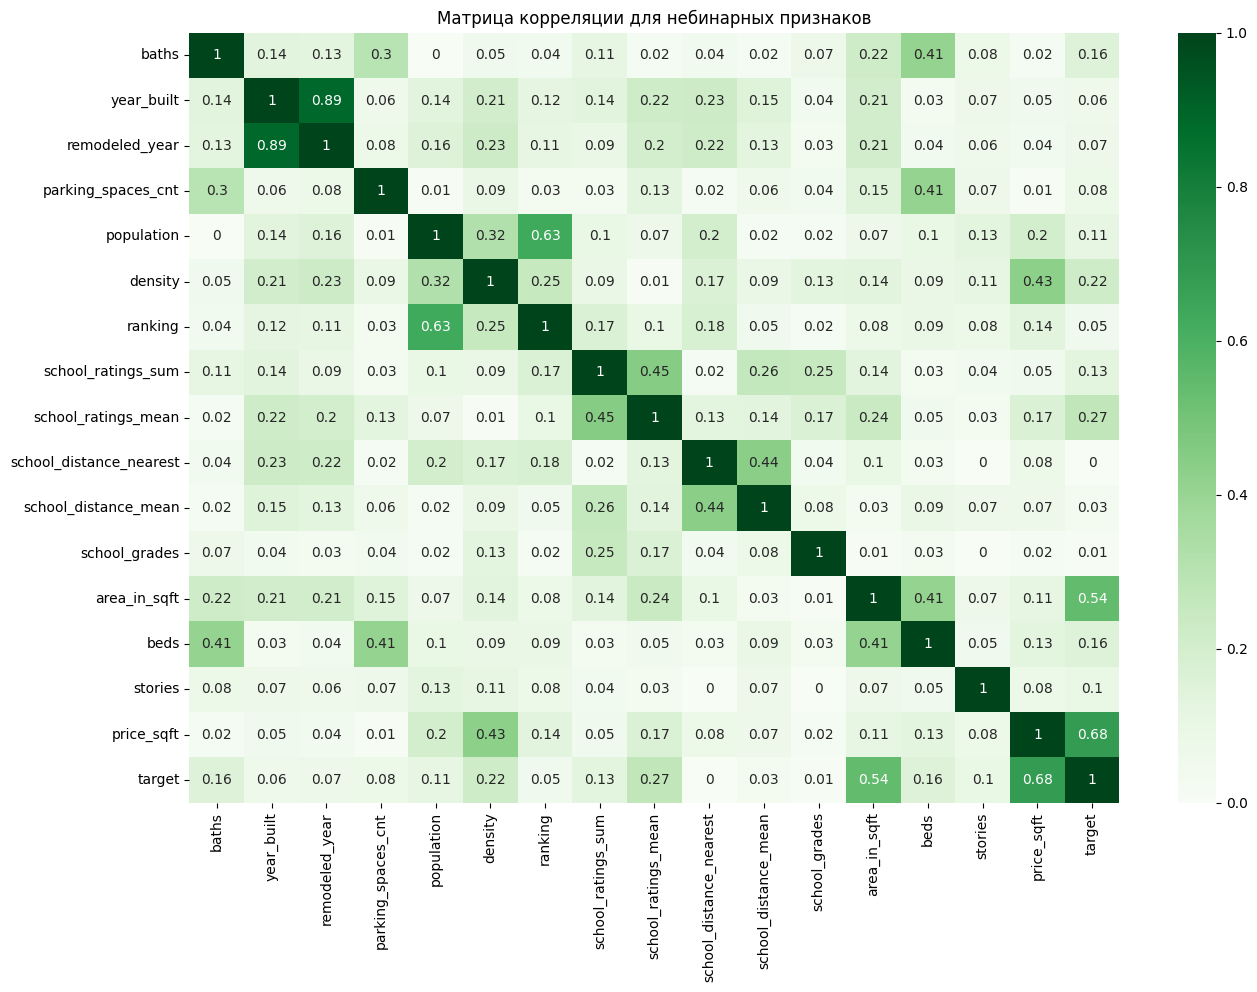

In [66]:
plt.figure(figsize=(15, 10))
sns.heatmap(realty_data[numeric_cols].corr().abs().round(2), annot=True, cmap='Greens')

plt.title('Матрица корреляции для небинарных признаков')
plt.show()

> Мультиколлинеарности в данных не выявлено, однако есть сильно коррелирующие между собой признаки годов постройки и ремонта. А вот с таргетом больше всего коррелируют цена за кв. фут, площадь, средний рейтинг школ и плотность населения в городе. Именно они и станут самыми важными для будущей модели. 

* #### Сохранение данных и переход к следующей части работы
> Поскольку данный ноутбук уже довольно большой и в нем уже трудно ориентироваться, на GitHub он может просто перестать показываться. Так что я сохраняю уже обработанные данные в .csv файл и продолжаю работу в ноутбуке *modeling.ipynb*.

In [67]:
realty_data.to_csv('data/data_new.csv', index=False)